# Ch. 10 - New frills for our neural network
Alternative title: Lots of important features that deep learning research has brought us to build better models.

So far, we have worked with four components:
- Sigmoid activations for binary classification
- Softmax activations for multiclass classification
- Tanh activations for hidden layers
- Vanilla gradient descent

But of course there is more. In this chapter we will explore 6 important tools:
- The relu activation function for hidden layers
- momentum
- The adam optimizer
- Regularization
- Dropout
- Batchnorm

But first, of course, let's load some libraries.

In [1]:
import numpy as np
import pandas as pd
# Set seed for reproducability 
np.random.seed(42)
import matplotlib.pyplot as plt

## The data
In the last chapter we already preprocessed the data:

In [2]:
df = pd.read_csv('processed_bank.csv',index_col=0)

To make sure that nothing got lost in transition, let's check the data by displaying the first few rows and checking the dimensions of our dataset:

In [3]:
# Display first few (5) rows
df.head()

,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,...,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,contacted_before
34579,-0.68711,-2.555677e-13,0.976408,-0.758550,-0.928102,-1.122929,-0.900202,-0.418322,0,1,...,0,0,0,1,0,0,1,0,0,0
446,-0.68711,-2.555677e-13,-0.452557,0.924213,0.806766,0.705671,0.998971,0.637509,1,0,...,0,0,0,0,1,0,0,1,0,0
20173,-0.13552,-2.555677e-13,-0.452557,1.098292,-0.059880,0.761649,1.056089,1.063747,1,1,...,0,0,1,0,0,0,0,1,0,0
18171,-0.13552,-2.555677e-13,-0.452557,1.098292,0.687012,-0.469858,1.055031,1.063747,1,1,...,0,0,0,0,0,1,0,1,0,0
30128,-0.68711,-2.555677e-13,-0.452557,-0.758550,-0.641321,-1.290862,-0.847844,-0.418322,0,0,...,0,0,0,1,0,0,0,1,0,0


In [4]:
# Check shape of dataset
df.shape

(9280, 65)

Everything looks good, like we would have expected it. Now it is time to split the input $X$ from the labels $y$

In [5]:
# X is everything that is not y
X = df.loc[:, df.columns != 'y'].values
# y is y
y = df['y'].values

## Train / Dev / Test
So far, we have worked with a trainings and a test set. From now on, we will have a training, test, and at least one dev set. The dev set is used for hyper parameter optimization. We train our model with the trainings set, and then we try it out on the dev set. We can then use the insight gained from evaluating the model on the dev set to tweak the parameters. We can not do this with the test set, because every time we use the insight gained from evaluation on a certain dataset we compromise the datasets neutrality. When we would tweak our hyper parameters on the test set, it would no longer be a totally new and unseen dataset for our model. By tweaking the hyper parameters to fit on the test set, we would run the risk of over fitting to the test set. That is why we have a dev set, we can tweak hyper parameters on. After we have tweaked the hyper parameters for a bit and are satisfied with the results on the dev set, we might try our model on the test set. The important part is that we do not use any insight from the test set evaluation to tweak our model, or we would have to get a new, unseen, test set.

In [6]:
# First split in train / test_dev
from sklearn.model_selection import train_test_split
X_train, X_test_dev, y_train, y_test_dev = train_test_split(X, y, test_size=0.25, random_state=0)

# Second split in dev / test
X_dev, X_test, y_dev, y_test = train_test_split(X_test_dev, y_test_dev, test_size=0.5, random_state=0)

# Remove test_dev set from memory
del X_test_dev
del y_test_dev

## The baseline model
Before diving into more complicated models and adding a lot of features to our network, it makes sense to start out with just a very simple logistic regression model. That way, we can verify that our data is ready for training and see how well a very simple model would do. Whenever we add new features, we should make sure that our new model actually does better than simple logistic regression.

In [7]:
# Get Keras
# We will build a simple sequential model
from keras.models import Sequential
# Using fully connected layers
from keras.layers import Dense
# With vanilla gradient descent
from keras.optimizers import SGD

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Remember that logistic regression is a neural network with only one layer. In this layer, every input feature is connected to the output. It uses a sigmoid activation function and a binary crossentropy loss (also called logistic loss or log loss). Here, we are setting the learning rate to 0.01, which is actually the standard value that Keras would have used anyway.

In [8]:
# Sequential model
model = Sequential()

# Logistic regresison is a single layer network
model.add(Dense(1,activation='sigmoid',input_dim=64))

# Compile the model
model.compile(optimizer=SGD(lr=0.01),loss='binary_crossentropy',metrics=['acc'])

We will use TensorBoard throughout this chapter, to compare graphically how different approaches learn. We will set up each new model with its own name, so don't worry about time stamps as names for now.

In [9]:
from keras.callbacks import TensorBoard 

In [10]:
tensorboard = TensorBoard(log_dir='./logs/'+ 'logistic regression')

We will train this model using batch gradient descent, that is we will process all of our training examples at once. We can do this since we do not have very many training examples and the size of each individual example is quite small, just a 64 number per row. If you have a computer with little RAM you might consider using a smaller batch size than the whole trainings set.

In [11]:
history_log = model.fit(X_train, y_train, epochs=1000, batch_size=X_train.shape[0], callbacks=[tensorboard], verbose=0)

In this notebook we suppress the Keras output to keep it readable but plot the accuracy and loss over the training epochs:

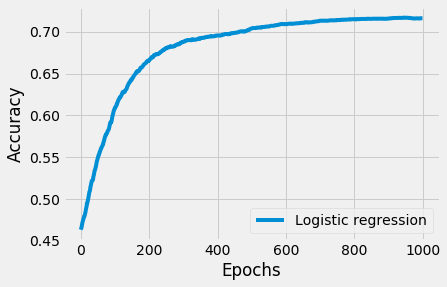

In [12]:
plt.style.use('fivethirtyeight')
plt.plot(history_log.history['acc'], label = 'Logistic regression')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

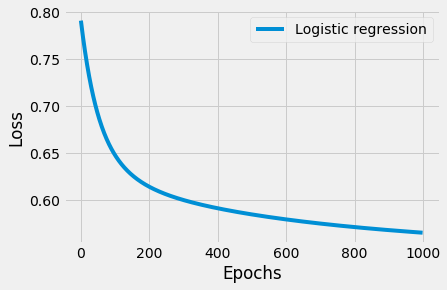

In [13]:
plt.plot(history_log.history['loss'], label='Logistic regression')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
model.evaluate(x=X_dev,y=y_dev)

  32/1160 [..............................] - ETA: 0s

[0.57184929518864069, 0.72413793103448276]

Our model achieves about 71% accuracy, that is, for 71% of all times it was right. Let's see if we can do better.

## A bigger network (tanh activation)
Earlier we already learned how to build a bigger network with a tanh activation for hidden layers, lets try the same thing here:

In [15]:
# Sequential model
model = Sequential()

# First hidden layer
model.add(Dense(32,activation='tanh',input_dim=64))

# Second hidden layer
model.add(Dense(16,activation='tanh'))

# Output layer
model.add(Dense(1,activation='sigmoid'))

# Compile the model
model.compile(optimizer=SGD(lr=0.01),
              loss='binary_crossentropy',
              metrics=['acc'])

# Set up tensorboard with a new name
tensorboard = TensorBoard(log_dir='./logs/'+ 'tanh two hidden layers')

# Train
history_tanh = model.fit(X_train, y_train, # Train on training set
                         epochs=1000, # We will train over 1,000 epochs
                         batch_size=X_train.shape[0], # Batch size = training set size
                         callbacks=[tensorboard], # Render to tensorboard
                         verbose=0) # Suppress Keras output

Let's plot accuracy and loss development in comparison to plain logistic regression (just in case you have not already looked it up in TensorBoard):

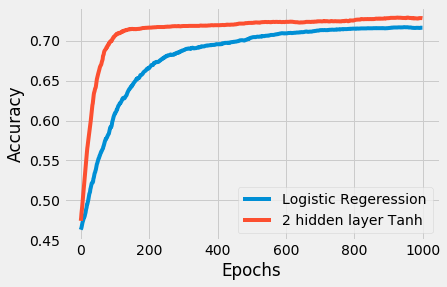

In [16]:
plt.plot(history_log.history['acc'], label= 'Logistic Regeression')
plt.plot(history_tanh.history['acc'], label= '2 hidden layer Tanh')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

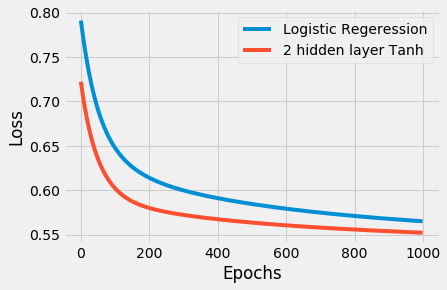

In [17]:
plt.plot(history_log.history['loss'], label= 'Logistic Regeression')
plt.plot(history_tanh.history['loss'], label= '2 hidden layer Tanh')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From these graphs it looks like the model learned a lot better than logistic regression, let's evaluate it on the dev set:

In [18]:
model.evaluate(x=X_dev,y=y_dev)

  32/1160 [..............................] - ETA: 0s

[0.55851438045501711, 0.72586206896551719]

In fact, a bigger network with a tanh activation does better here than just logistic regression, but there are other activations than tanh.

## The ReLu activation function
ReLu stands for rectified linear function. It can be expressed as follows:

$$relu(x) = \max(0,x)$$

And looks like this:
![ReLu](https://storage.googleapis.com/aibootcamp/Week%202/assets/relu.jpeg)

This very simple function has been shown to be quite useful, making gradient descent converge faster (see [Krizhevsky et. al.](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf)). It is often argued that ReLu is faster because its derivative for all values above zero is just one, and does not become very small as the derivative for extreme values does with sigmoid or tanh. ReLu is also less computationally expensive than either sigmoid or tanh. It does not require any computationally expensive calculations, input values below zero are just set to zero and the rest is outputted as is. Unfortunately, ReLu activations are a bit fragile and can 'die'. When the gradient is very large and moves many weights in the negative direction then the derivative of ReLu will also always be zero, so the weights never get updated again. This might mean that a neuron never fires again. This can be mitigated through a smaller learning rate.

Because ReLu is fast and computationally cheap it has become the default activation functions for many practitioners. In Keras, we can swap tanh for ReLu simply by changing the name of the activation. Keras supports a wide range of different application functions, to learn more about them, check out the [official documentation](https://keras.io/activations/).

In [19]:
# Sequential model
model = Sequential()

# First hidden layer now with relu!
model.add(Dense(32,activation='relu',input_dim=64))

# Second hidden layer now with relu!
model.add(Dense(16,activation='relu'))

# Output layer stayed sigmoid
model.add(Dense(1,activation='sigmoid'))

# Compile the model
model.compile(optimizer=SGD(lr=0.01),
              loss='binary_crossentropy',
              metrics=['acc'])

# Set up tensorboard with a new name
tensorboard = TensorBoard(log_dir='./logs/'+ 'ReLu two hidden layers')

# Train
history_relu = model.fit(X_train, y_train, # Train on training set
                         epochs=1000, # We will train over 1,000 epochs
                         batch_size=X_train.shape[0], # Batch size = training set size
                         callbacks=[tensorboard], # Render to tensorboard
                         verbose=0) # Suppress Keras output

If we plot the loss curves of both tanh and relu (in red) next to each other you can see that relu does in fact learn a little bit faster on this dataset. There is no real right or wrong for activation functions, but ReLu is a popular choice.

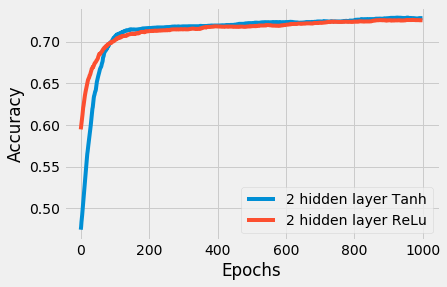

In [20]:
plt.plot(history_tanh.history['acc'], label='2 hidden layer Tanh')
plt.plot(history_relu.history['acc'], label='2 hidden layer ReLu')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

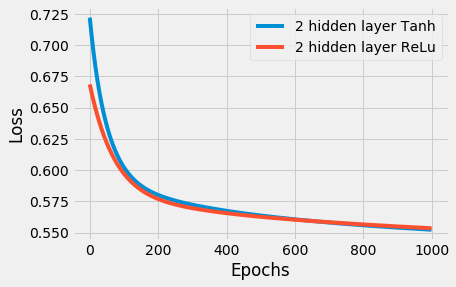

In [21]:
plt.plot(history_tanh.history['loss'], label='2 hidden layer Tanh')
plt.plot(history_relu.history['loss'], label='2 hidden layer ReLu')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Momentum
Earlier, we motivated gradient descent as someone trying to find the way down a hill by just following the slope of the floor. Momentum can be motivated with an analogy to physics, where a ball is rolling down the same hill. A small bump in the hill would not make the ball roll in a completely different direction. The ball has some momentum, meaning that its movement gets influenced by its previous movement. The same can be added to gradient descent. 

Instead of directly updating the model parameters with their gradient we update them with the moving average (technically the [exponentially weighted moving average](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average)). We can also motivate this from statistics: To avoid that we update our parameter with an outlier gradient, we take the moving average, which will smoothen out outliers and capture the general direction of the gradient.
![Momentum](https://storage.googleapis.com/aibootcamp/Week%202/assets/momentum.jpg)
Mathematically:

$$V_{dW} = \beta * V_{dW} + (1 - \beta) * dW$$
$$W = W - \alpha * V_{dW}$$

A typical value for beta would be 0.9, meaning that 90% of the update comes from previous gradients. In Keras we can add momentum through gradient descent by specifying a value for beta, by default it is set to 0.

In [22]:
# Sequential model
model = Sequential()

# First hidden layer
model.add(Dense(32,activation='relu',input_dim=64))

# Second hidden layer
model.add(Dense(16,activation='relu'))

# Output layer
model.add(Dense(1,activation='sigmoid'))

# Setup optimizer with learning rate of 0.01 and momentum (beta) of 0.9
momentum_optimizer = SGD(lr=0.01, momentum=0.9)

# Compile the model
model.compile(optimizer=momentum_optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

# Set up tensorboard with a new name
tensorboard = TensorBoard(log_dir='./logs/'+ 'Momentum ReLu two hidden layers')

# Train
history_momentum = model.fit(X_train, y_train, # Train on training set
                             epochs=1000, # We will train over 1,000 epochs
                             batch_size=X_train.shape[0], # Batch size = training set size
                             callbacks=[tensorboard], # Render to tensorboard
                             verbose=0) # Suppress Keras output

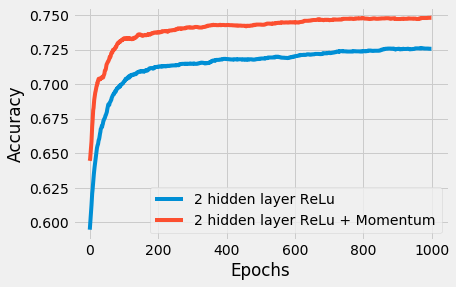

In [23]:
plt.plot(history_relu.history['acc'], label= '2 hidden layer ReLu')
plt.plot(history_momentum.history['acc'], label= '2 hidden layer ReLu + Momentum')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

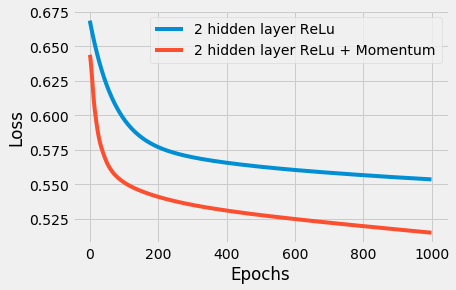

In [24]:
plt.plot(history_relu.history['loss'], label= '2 hidden layer ReLu')
plt.plot(history_momentum.history['loss'], label= '2 hidden layer ReLu + Momentum')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As you can see, with momentum, our model learned much better than before! Let's evaluate it on the dev set:

In [25]:
model.evaluate(x=X_dev,y=y_dev)

  32/1160 [..............................] - ETA: 1s

[0.54323123035759757, 0.73189655172413792]

## The adam optimizer
[Kingma, D. P., & Ba, J. L. (2015)](https://arxiv.org/abs/1412.6980)'s adam (adaptive momentum estimation) optimizer is another way to make gradient descent work better that has shown very good results and has therefore become a standard choice for many practitioners. First it computes the exponentially weighted average of the gradients, just like a momentum optimizer does:
$$V_{dW} = \beta_1 * V_{dW} + (1 - \beta_1) * dW$$

But then it also computes the exponentially weighted average of the _squared_ gradients:

$$S_{dW} = \beta_2 * S_{dW} + (1 - \beta_2) * dW^2$$

It then updates the model parameters like this:

$$ W = W - \alpha * \frac{V_{dW}}{\sqrt{S_{dW}} + \epsilon}$$

Where $\epsilon$ is a very small number to avoid division by zero.

This division by the root of squared gradients reduces the update speed when gradients are very large. This stabilizes learning as the learning algorithm does not get thrown off track by outliers as much. Together with adam, we got a new hyper parameter. Instead of having just one momentum factor $\beta$ we now have two, $\beta_1$ and $\beta_2$. The recommended values for $\beta_1$ and $\beta_2$ are 0.9 and 0.999 respectively. We can use adam in keras like this:

In [26]:
from keras.optimizers import adam

In [27]:
# Sequential model
model = Sequential()

# First hidden layer
model.add(Dense(32,activation='relu',input_dim=64))

# Second hidden layer
model.add(Dense(16,activation='relu'))

# Output layer stayed sigmoid
model.add(Dense(1,activation='sigmoid'))

# Setup adam optimizer
adam_optimizer=adam(lr=0.1,
                beta_1=0.9, 
                beta_2=0.999, 
                epsilon=1e-08)

# Compile the model
model.compile(optimizer=adam_optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

# Set up tensorboard with a new name
tensorboard = TensorBoard(log_dir='./logs/'+ 'Adam ReLu two hidden layers')

# Train
history_adam = model.fit(X_train, y_train, # Train on training set
                         epochs=1000, # We will train over 1,000 epochs
                         batch_size=X_train.shape[0], # Batch size = training set size
                         callbacks=[tensorboard], # Render to tensorboard
                         verbose=0) # Suppress Keras output

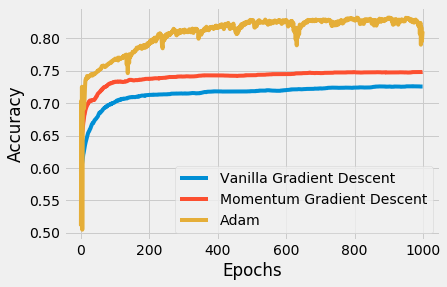

In [28]:
plt.plot(history_relu.history['acc'], label = 'Vanilla Gradient Descent')
plt.plot(history_momentum.history['acc'], label = 'Momentum Gradient Descent')
plt.plot(history_adam.history['acc'], label = 'Adam')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

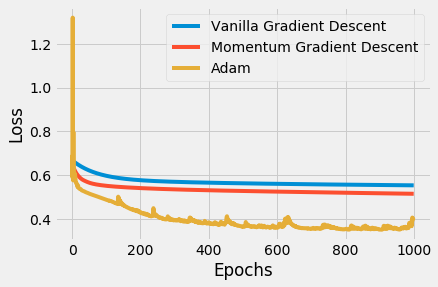

In [29]:
plt.plot(history_relu.history['loss'], label = 'Vanilla Gradient Descent')
plt.plot(history_momentum.history['loss'], label = 'Momentum Gradient Descent')
plt.plot(history_adam.history['loss'], label = 'Adam')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
model.evaluate(x=X_dev,y=y_dev)

  32/1160 [..............................] - ETA: 2s

[1.2467755860295788, 0.68448275862068964]

The model learns very well on the training set, but it does less well on the dev set. It is overfitting the training set. We can counter this with a technique called regularization.

## Regularization
Regularization is a technique to avoid overfitting. Overfitting is when the model fits the training data too well and does not generalize well to dev or test data. 

### L2 Regularization
One popular technique to counter this is L2 regularization. L2 regularization adds the sum of squared weights to the loss function like this:

$$L(W)_{Regularized} = L(W) + \frac{\lambda}{2N}\sum W^2$$

Where $N$ is the number of training examples, and $\lambda$ is the regularization hyper parameter that influences how much we want to regularize.

Adding this regularization to the loss function means that high weights increase losses and the algorithm is incentivised to reduce weights. Small weights (around zero) mean that the neural network relies less on them. Therefore, a regularized algorithm will rely less on every single feature and every single node activation and will have a more holistic view, taking into account many features and activations. This will prevent the algorithm from overfitting. A common value for $\lambda$ is around 0.01.

### L1 Regularization
L1 regularization is very similar to L2 regularization but instead of adding the sum of squares it adds the sum of absolute values:

$$L(W)_{Regularized} = L(W) + \frac{\lambda}{2N}\sum||W||$$

In practice it is often a bit experimental which of the two works best, the difference is not very large.

### L2 & L1 in Keras
In Keras, regularizers that are applied to the weights are called ``kernel_regularizer``, regularizers that are applied to the bias are called ``bias_regularizer``. You can also apply regularization directly to the activation of the nodes to prevent them from being activated very strongly with ``activity_regularizer``. Let's add some L2 regularization to our overfitting network:

In [31]:
from keras import regularizers

In [32]:
# Sequential model
model = Sequential()

# First hidden layer now regularized
model.add(Dense(32,activation='relu',
                input_dim=64,
                kernel_regularizer = regularizers.l2(0.01)))

# Second hidden layer now regularized
model.add(Dense(16,activation='relu',
                   kernel_regularizer = regularizers.l2(0.01)))

# Output layer stayed sigmoid
model.add(Dense(1,activation='sigmoid'))

# Setup adam optimizer
adam_optimizer=adam(lr=0.1,
                beta_1=0.9, 
                beta_2=0.999, 
                epsilon=1e-08)

# Compile the model
model.compile(optimizer=adam_optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

# Set up tensorboard with a new name
tensorboard = TensorBoard(log_dir='./logs/'+ 'Regularized two hidden layers')

# Train
history_regularized=model.fit(X_train, y_train, # Train on training set
                             epochs=1000, # We will train over 1,000 epochs
                             batch_size=X_train.shape[0], # Batch size = training set size
                             callbacks=[tensorboard], # Render to tensorboard
                             verbose=0) # Suppress Keras output

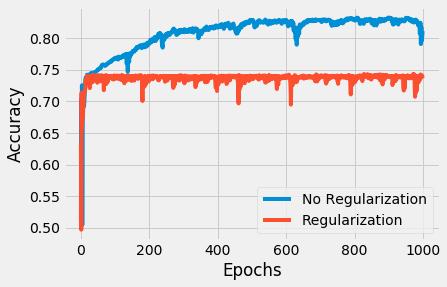

In [33]:
plt.plot(history_adam.history['acc'], label = 'No Regularization')
plt.plot(history_regularized.history['acc'], label = 'Regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

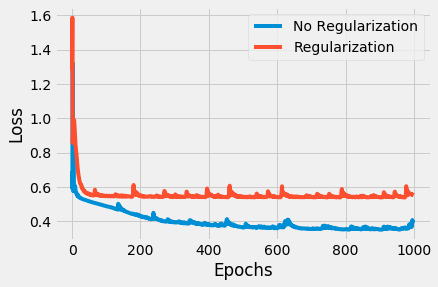

In [34]:
plt.plot(history_adam.history['loss'], label = 'No Regularization')
plt.plot(history_regularized.history['loss'], label = 'Regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
model.evaluate(x=X_dev,y=y_dev)

  32/1160 [..............................] - ETA: 2s

[0.55295078631105099, 0.73620689655172411]

The regularized model achieves a lower performance on the training set but if we test it with the dev set it does significantly better. We have successfully reduced overfitting!

## Dropout
As the original paper title gives away, Dropout is ["A Simple Way to Prevent Neural Networks from
Overfitting"](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). And it works by randomly removing nodes from the neural network:
![Dropout](https://storage.googleapis.com/aibootcamp/Week%202/assets/dropout.png)

With dropout, each node has a small probability of having it's activation set to zero. This means that the learning algorithm can no longer rely heavily on single nodes, much like in L2 and L1 regularization. Dropout therefore also has a regularizing effect.

In Keras, dropout is [a new type of layer](https://keras.io/layers/core/#dropout). It is put after the activations you want to apply dropout to. It passes on activations, but sometimes it sets them to zero, achiving the same effect as dropout in the cells directly:

In [36]:
from keras.layers import Dropout

In [37]:
# Sequential model
model = Sequential()

# First hidden layer
model.add(Dense(32,activation='relu',
                input_dim=64))

# Add dropout layer
model.add(Dropout(rate=0.5))

# Second hidden layer
model.add(Dense(16,activation='relu'))


# Add another dropout layer
model.add(Dropout(rate=0.5))

# Output layer stayed sigmoid
model.add(Dense(1,activation='sigmoid'))

# Setup adam optimizer
adam_optimizer=adam(lr=0.1,
                beta_1=0.9, 
                beta_2=0.999, 
                epsilon=1e-08)

# Compile the model
model.compile(optimizer=adam_optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

# Set up tensorboard with a new name
tensorboard = TensorBoard(log_dir='./logs/'+ 'Dropout two hidden layers')

# Train
history_dropout = model.fit(X_train, y_train, # Train on training set
                             epochs=1000, # We will train over 1,000 epochs
                             batch_size=X_train.shape[0], # Batch size = training set size
                             callbacks=[tensorboard], # Render to tensorboard
                             verbose=0) # Suppress Keras output

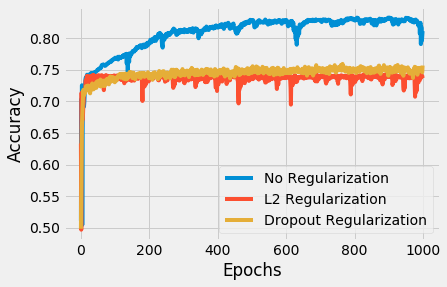

In [38]:
plt.plot(history_adam.history['acc'], label = 'No Regularization')
plt.plot(history_regularized.history['acc'], label = 'L2 Regularization')
plt.plot(history_dropout.history['acc'], label = 'Dropout Regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

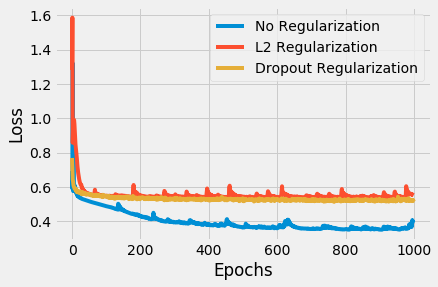

In [39]:
plt.plot(history_adam.history['loss'], label = 'No Regularization')
plt.plot(history_regularized.history['loss'], label = 'L2 Regularization')
plt.plot(history_dropout.history['loss'], label = 'Dropout Regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Note that when the model is evaluated or used to make actual predictions dropout should be deactived to get the best results. Keras does this automatically.

In [40]:
model.evaluate(x=X_dev,y=y_dev)

  32/1160 [..............................] - ETA: 2s

[0.69314079654627836, 0.72931034482758617]

## Batchnorm
Remember how we normalized our input in chapter 9? 
![Feature Scaling](https://storage.googleapis.com/aibootcamp/Week%202/assets/feature_scaling.jpg)

That made it easier for our learning algorithm because the loss function was more 'round'. What was true for features is true inside the neural network as well. When we add normalization into the neural network, the mean and variance that are required for normalization get calculate from the batch that the network is currently training on, not the whole dataset. This is why this process is called batch normalization, or batchnorm.

In Keras, batchnorm is a new layer that gets put behind the linear step and before the normalization. This requires is the separate the linear step and activation in Keras.

### Batchnorm VS Feature scaling

Batchnorm and feature scaling have many similar traits. They are often used together.

|Batchnorm|Feature Scaling|
|---------|---------------|
|Applied to layer activations|Applied to input only|
|Adaptively calculates mean and standard deviation|Mean & Std caluclated once over dataset|

In [41]:
from keras.layers import BatchNormalization
from keras.layers import Activation

In [42]:
# Sequential model
model = Sequential()

# Input layer linear step
model.add(Dense(32, input_dim=64))

# Input layer normalization
model.add(BatchNormalization())

# Input layer activation
model.add(Activation('relu'))

# Add dropout layer
model.add(Dropout(rate=0.5))

# hidden layer linear step
model.add(Dense(16))

# Hidden layer normalization
model.add(BatchNormalization())

# Hidden layer activation
model.add(Activation('relu'))

# Add another dropout layer
model.add(Dropout(rate=0.5))

# Output layer, 
model.add(Dense(1))

# Output normalization
model.add(BatchNormalization())

# Output layer activation
model.add(Activation('sigmoid'))

# Setup adam optimizer
adam_optimizer=adam(lr=0.1,
                beta_1=0.9, 
                beta_2=0.999, 
                epsilon=1e-08)

# Compile the model
model.compile(optimizer=adam_optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

# Set up tensorboard with a new name
tensorboard = TensorBoard(log_dir='./logs/'+ 'Dropout + Batchnorm')

# Train
history_batchnorm = model.fit(X_train, y_train, # Train on training set
                             epochs=1000, # We will train over 1,000 epochs
                             batch_size=X_train.shape[0], # Batch size = training set size
                             callbacks=[tensorboard], # Render to tensorboard
                             verbose=0) # Suppress Keras output

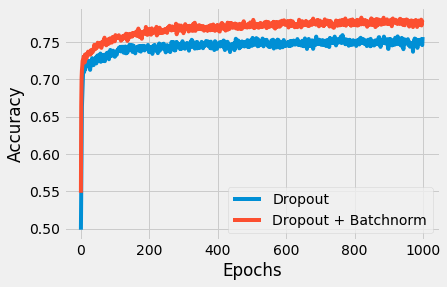

In [43]:
plt.plot(history_dropout.history['acc'], label = 'Dropout')
plt.plot(history_batchnorm.history['acc'], label = 'Dropout + Batchnorm')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

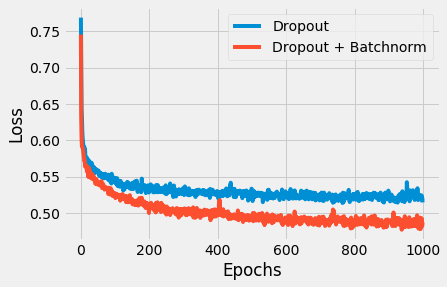

In [44]:
plt.plot(history_dropout.history['loss'], label = 'Dropout')
plt.plot(history_batchnorm.history['loss'], label = 'Dropout + Batchnorm')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
model.evaluate(x=X_dev,y=y_dev)

1160/1160 [==============================] - 0s     


[0.62175416124278104, 0.7068965517241379]

## Summary
And thus concludes our little safari through the wonderful world of things you can add to your vanilla neural network. There are many more [optimizers](https://keras.io/optimizers/), [activation functions](https://keras.io/activations/) and things we have not even touched at such as better [random initializers](https://keras.io/initializers/). The tools shown here however are kind of the evergreens that get used quite often.